## Wakefield simulation of accelerator cavity with `wakis` using multi-processing

This notebook complements example `001` showcasing the use of multi-processing to split the simulation domain in several cores to achieve faster and memory-efficient calculations. 

* `ipyparallel` is used to start an IPython kernel. Each cell marked with `%%px` will be execued in parallel on al the kernel cores.
* `mpi4py` is used like in regular `.py` scripts to handle MPI communication
* `cupy` thorugh the environment variable `'OMPI_MCA_opal_cuda_support'`, the solver can detect several GPU cores and send the splitted the domain to them

In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="mpi", n=2).start_and_connect_sync()

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

In [2]:
%%px
# If multi-GPU
import os
os.environ['OMPI_MCA_opal_cuda_support']='true'

In [3]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print(f"Process {rank} of {size} is running")

# If multi-GPU
# import cupy
# cupy.cuda.Device(rank).use()

[stdout:1] Process 1 of 2 is running


[stdout:0] Process 0 of 2 is running


Import packages as usual, now starting with the magic `%%px` to execute it in all MPI ranks

In [4]:
%%px
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from wakis import SolverFIT3D
from wakis import GridFIT3D
from wakis import WakeSolver

from tqdm import tqdm

### Domain setup:
* __Capital variables__ are used as a convention to designate GLOBAL domain quantities: `NZ`, `ZMIN`, `ZMAX`
* __Lower case variables__ `Nz`, `zmin`, `zmax` will be associated to MPI subdomains and will be different for each `rank`. 
    * This quantities will be computed inside `GridFIT3D` when `use_mpi=True`

In [5]:
%%px
# ---------- Domain setup ---------
# Geometry & Materials
solid_1 = 'data/001_vacuum_cavity.stl'
solid_2 = 'data/001_lossymetal_shell.stl'

stl_solids = {'cavity': solid_1,
              'shell': solid_2
              }

stl_materials = {'cavity': 'vacuum',
                 'shell': [300, 1.0, 300] #[eps_r, mu_r, sigma[S/m]]
                 }

# Extract domain bounds from geometry
solids = pv.read(solid_1) + pv.read(solid_2)
xmin, xmax, ymin, ymax, ZMIN, ZMAX = solids.bounds

# Number of mesh cells
Nx = 95//2
Ny = 95//2
NZ = 250//2

In [6]:
%%px
grid = GridFIT3D(xmin, xmax, ymin, ymax, ZMIN, ZMAX,
                Nx, Ny, NZ,
                use_mpi = True,
                stl_solids=stl_solids,
                stl_materials=stl_materials,
                stl_scale=1.0,
                stl_rotate=[0,0,0],
                stl_translate=[0,0,0],
                verbose=2)

print(f"Process {rank}: Handling Z range {grid.zmin} to {grid.zmax} with {grid.Nz} cells")

[stdout:0] Generating grid with 276125 mesh cells...
 * Simulation domain bounds: 
                    x:[-0.260, 0.260],
                    y:[-0.260, 0.260],
                    z:[-0.250, 0.550]
 * Global grid ZMIN=-0.25, ZMAX=0.550000011920929, NZ=124
MPI rank 0 of 2 initialized with                         zmin=-0.25, zmax=0.15000000596046448, Nz=62
MPI initialized for 0 of 2
Importing STL solids...
 * STL solid cavity: 37575 cells marked inside the solid.
[!] Warning: stl solid shell may have issues with closed surfaces.                         Consider checking the STL file.
 * STL solid shell: 24843 cells marked inside the solid.
Total grid initialization time: 2.1829488277435303 s
Process 0: Handling Z range -0.25 to 0.15645161895982682 with 63 cells


[stdout:1] Generating grid with 276125 mesh cells...
 * Simulation domain bounds: 
                    x:[-0.260, 0.260],
                    y:[-0.260, 0.260],
                    z:[-0.250, 0.550]
MPI rank 1 of 2 initialized with                         zmin=0.15000000596046448, zmax=0.550000011920929, Nz=62
MPI initialized for 1 of 2
Importing STL solids...
 * STL solid cavity: 37569 cells marked inside the solid.
[!] Warning: stl solid shell may have issues with closed surfaces.                         Consider checking the STL file.
 * STL solid shell: 24843 cells marked inside the solid.
Total grid initialization time: 2.2444536685943604 s
Process 1: Handling Z range 0.14354839296110214 to 0.550000011920929 with 63 cells


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

### Solver definition
* We define our solver as for a non-MPI simulation, just passing `use_mpi=True`

In [7]:
%%px
# boundary conditions
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

# Solver setup
solver = SolverFIT3D(grid,
                    bc_low=bc_low,
                    bc_high=bc_high,
                    use_stl=True,
                    use_mpi=True,
                    use_gpu=False, # True if multi-GPU
                    bg='pec' # Background material
                    )

# image folder creation
img_folder = '001b_img/'
if not os.path.exists(img_folder):
    if rank == 0:
        os.mkdir(img_folder)

[stdout:0] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Using MKL backend for time-stepping...
Total solver initialization time: 0.21652007102966309 s


[stdout:1] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Using MKL backend for time-stepping...
Total solver initialization time: 0.21221208572387695 s


We can visualize our conductivity tensor $\sigma$ for each rank subdomain:

[output:1]

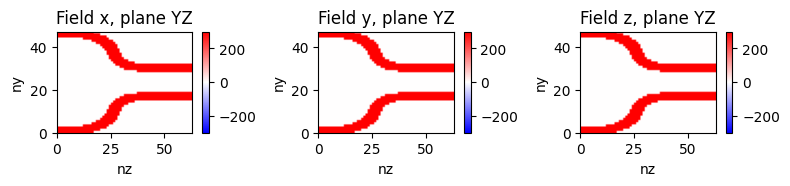

[output:0]

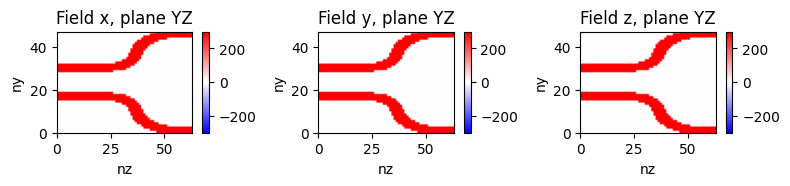

In [8]:
%%px
solver.sigma.inspect()

## Custom Time loop with on-the-fly plotting
* We can run our simulation as usual, only changing the field advance to `mpi_one_step()`

We generate our beam source as per a non-MPI simulation:

In [9]:
%%px
# ------------ Beam source & Wake ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s]

# Simualtion
wakelength = 10. # [m]
add_space = 10   # no. cells to skip from boundaries - removes BC artifacts

from wakis.sources import Beam
from scipy.constants import c
beam = Beam(q=q, sigmaz=sigmaz, beta=beta,
            xsource=xs, ysource=ys, ti=3*sigmaz/c)

In [10]:
%%px
n = 0
solver.reset_fields()

plot_inspect = False
plot_2D = True
plot_1D = False

In [11]:
%%px
Nt = 3000
for n in tqdm(range(Nt)):

    beam.update(solver, n*solver.dt)

    solver.one_step()

    # Plot inspect every 20 timesteps
    if n%20 == 0 and plot_inspect:
        E = solver.mpi_gather_asField('E')
        if rank == 0:
            fig, ax = E.inspect(figsize=[20,6], plane='YZ', show=False, handles=True)
            fig.savefig(img_folder+'Einspect_'+str(n).zfill(4)+'.png')
            plt.close(fig)

    # Plot E abs in 2D every 20 timesteps
    if n%20 == 0 and plot_2D:
        solver.plot2D(field='E', component='Abs',
                    plane='YZ', pos=0.5,
                    cmap='rainbow', vmin=0, vmax=500., interpolation='hanning',
                    off_screen=True, title=img_folder+'Ez2d', n=n)

    # Plot E z in 1D at diferent transverse positions `pos` every 20 timesteps
    if n%20 == 0 and plot_1D:
        solver.plot1D(field='E', component='z',
              line='z', pos=[0.45, 0.5, 0.55], ylim=(-800, 800),
              xscale='linear', yscale='linear',
              off_screen=True, title=img_folder+'Ez1d', n=n)

[stderr:0] 100%|██████████| 3000/3000 [00:41<00:00, 71.98it/s]


[stderr:1] 100%|██████████| 3000/3000 [00:41<00:00, 71.98it/s]


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

### Post-processing
* We can generate a `GIF` animation from a notebook cell and display it in the notebook:
  
> Notice we don't need the `%%px` magic for this!

In [12]:
!convert -delay 10 -loop 0 001b_img/Ez2d*.png 001b_img/001b_Ez2d.gif
# !rm 001b_img/E*.png

In [13]:
# Use IPython to display the gif
from IPython.display import HTML
HTML('<img src="001b_img/001b_Ez2d.gif">')

Or direclty in markdown:

![Electric field gif](001b_img/001b_Ez2d.gif)

* We can also plot the last timestep's fields `E`, `H` or `J`

[output:0]

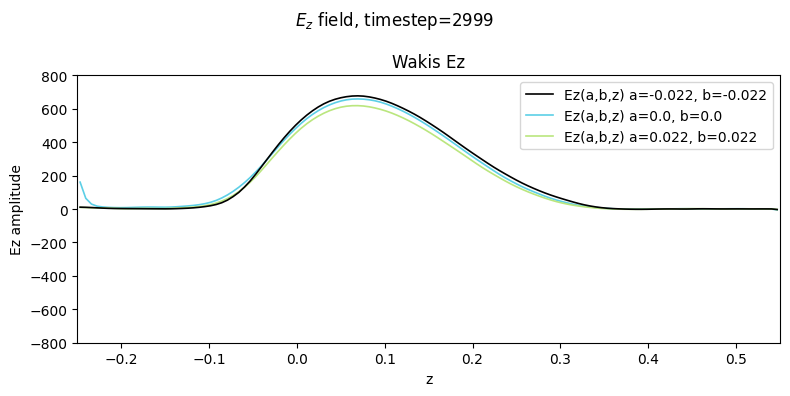

In [14]:
%%px
solver.plot1D(field='E', component='z',
              line='z', pos=[0.45, 0.5, 0.55], ylim=(-800, 800),
              xscale='linear', yscale='linear',
              off_screen=False, title=img_folder+'Ez1d', n=n)

[output:0]

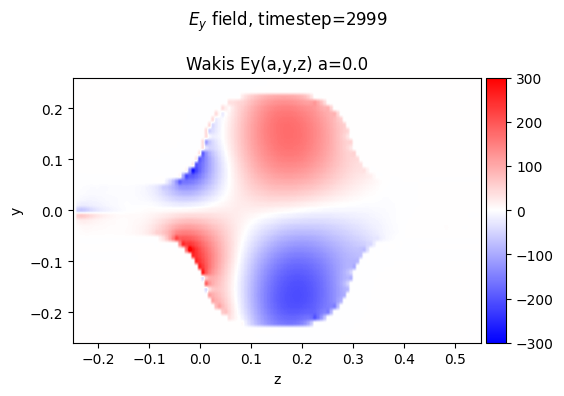

In [15]:
%%px
solver.plot2D(field='E', component='y',
            plane='YZ', pos=0.5,
            cmap='bwr', vmin=-300, vmax=300., interpolation='hanning',
            off_screen=False, title=img_folder+'Ez2d', n=n)

[output:0]

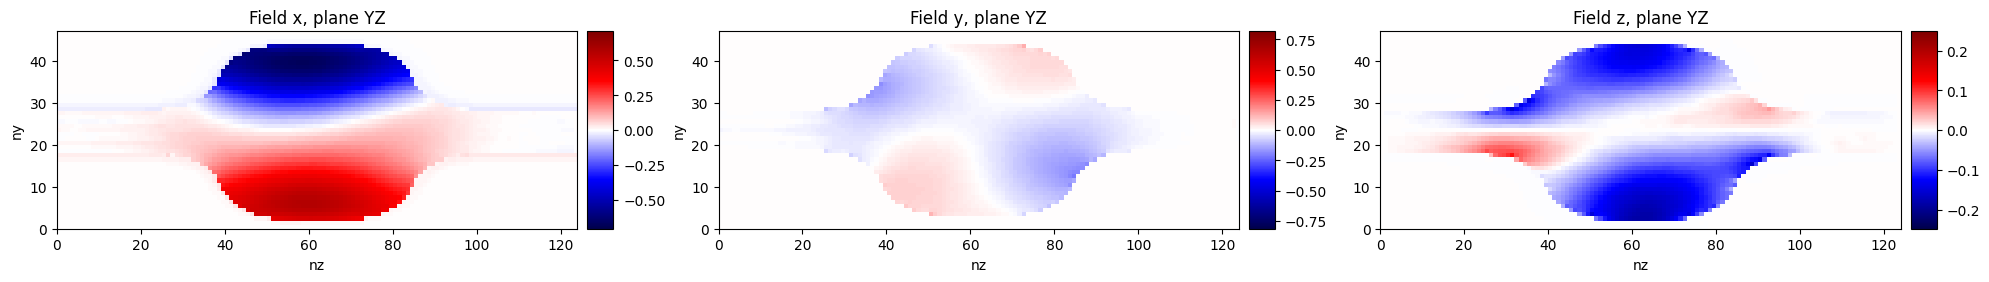

In [16]:
%%px
#gathers H field as a Field object to rank=0
H = solver.mpi_gather_asField('H')

# only plot in rank 0 where H has been gathered
if rank == 0:
    fig, ax = H.inspect(figsize=[20,6], cmap='seismic', plane='YZ', show=False, handles=True)
    plt.show()

## Wakefield simulation

In [17]:
%%px
n = 0
solver.reset_fields()

First we need to set up the wake object:

In [18]:
%%px
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s]


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 10. # [m] -> Partially decayed
skip_cells = 10   # no. cells to skip at zlo/zhi for wake integration
results_folder = '001b_results/'
wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                skip_cells=10,
                results_folder=results_folder,
                Ez_file=results_folder+'Ez.h5',)

Now we can run the wakefield simulation by doing:

In [19]:
%%px
solver.wakesolve(wakelength=wakelength, wake=wake,)

[stdout:1] Running electromagnetic time-domain simulation...


[stderr:1] 100%|██████████| 4680/4680 [00:30<00:00, 151.14it/s]


[stdout:0] Running electromagnetic time-domain simulation...
Reading h5 file 001b_results/Ez.h5
Calculating longitudinal wake potential WP(s)
Calculating transverse wake potential WPx, WPy...
Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


100%|██████████| 39258/39258 [00:00<00:00, 308999.54it/s]


%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[output:0]

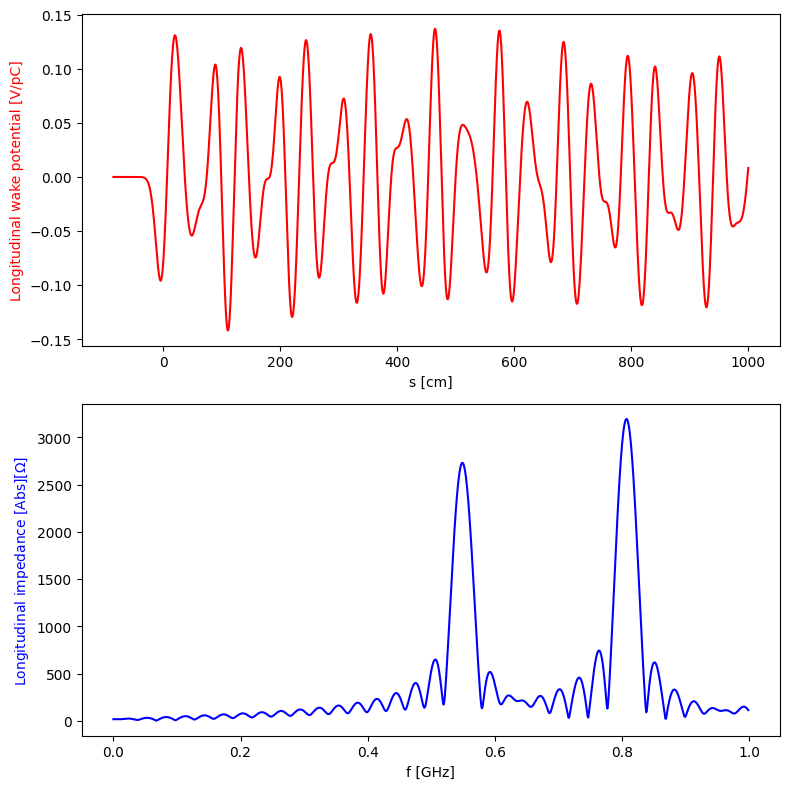

In [26]:
%%px
if solver.rank == 0:
    fig, ax = plt.subplots(2,1, figsize=[8,8])
    ax[0].plot(wake.s*1e2, wake.WP, c='r', lw=1.5, label='Wakis')
    ax[0].set_xlabel('s [cm]')
    ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

    ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='b', lw=1.5, label='Wakis')
    ax[1].set_xlabel('f [GHz]')
    ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')

    fig.tight_layout()

### Extrapolating to fully decayed impedance with `iddefix`

After the parallel simulation has been completed, we do not need the `%%px` anymore.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iddefix

from wakis import WakeSolver
from scipy.constants import c

Load previously computed results:

In [2]:
results_folder='001b_results/'
wake = WakeSolver()
wake.load_results(results_folder)

In [3]:
# We can recompute the impedance with less samples to increase the EA speed
wake.calc_long_Z(samples=1001, fmax=1.2e9)

Calculating longitudinal impedance Z...


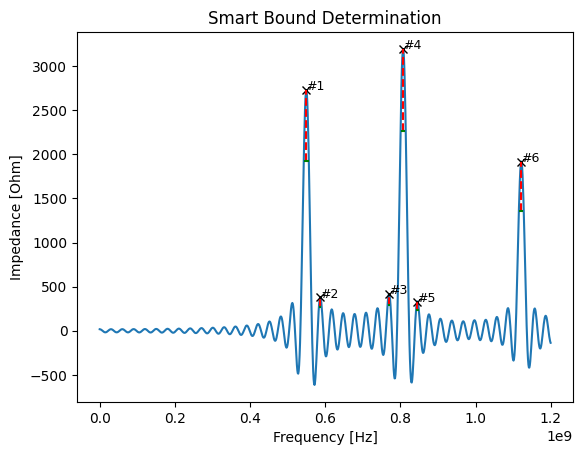


--------------------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |        fres [Hz]        
--------------------------------------------------------------------------------
    1     |  2182.35 to 27279.36   | 22.85 to 228.50  |  5.40e+08 to 5.60e+08   
    2     |   302.77 to 3784.61    | 61.00 to 610.00  |  5.77e+08 to 5.97e+08   
    3     |   330.86 to 4135.78    | 80.00 to 800.00  |  7.60e+08 to 7.80e+08   
    4     |  2556.55 to 31956.91   | 33.55 to 335.50  |  7.97e+08 to 8.17e+08   
    5     |   264.99 to 3312.43    | 58.50 to 585.00  |  8.35e+08 to 8.55e+08   
    6     |  1534.77 to 19184.59   | 46.60 to 466.00  |  1.11e+09 to 1.13e+09   
--------------------------------------------------------------------------------


In [4]:
# get bounds for the Differential Evolution fitting
bounds = wake.get_SmartBounds(freq_data=wake.f, impedance_data=wake.Z,
                        minimum_peak_height=330, distance=20, inspect_bounds=True,
                        Rs_bounds=[0.8, 10], Q_bounds=[0.5, 5], fres_bounds=[-0.01e9, +0.01e9]
                        )

Run the differential evolution:

In [9]:
DE_model = wake.get_DEmodel_fitting(freq_data=wake.f, impedance_data=wake.Z,
                                    plane='longitudinal', dim='z',
                                    parameterBounds=bounds.parameterBounds, N_resonators=bounds.N_resonators,
                                    DE_kernel='DE', maxiter=1e3, cmaes_sigma=0.6, popsize=30, tol=1e-3,
                                    use_minimization=True, minimization_margin=[0.3, 0.2, 0.01],
                                    verbose=False,)

[!] Using the partially decayed resonator formalism for impedance


Differential Evolution:  66%|██████▌   | 659/1000 [00:30<00:15, 21.95gen/s, conv=101.8 %]




----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.23e+04        |      228.49      |    5.495e+08     
    2     |        3.03e+02        |      602.29      |    5.866e+08     
    3     |        3.63e+02        |      764.30      |    7.801e+08     
    4     |        1.37e+04        |      314.33      |    8.075e+08     
    5     |        2.66e+02        |      583.60      |    8.514e+08     
    6     |        8.35e+03        |      465.90      |    1.122e+09     
----------------------------------------------------------------------
Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |

First, we can asses the fitting done by the differential evolution:

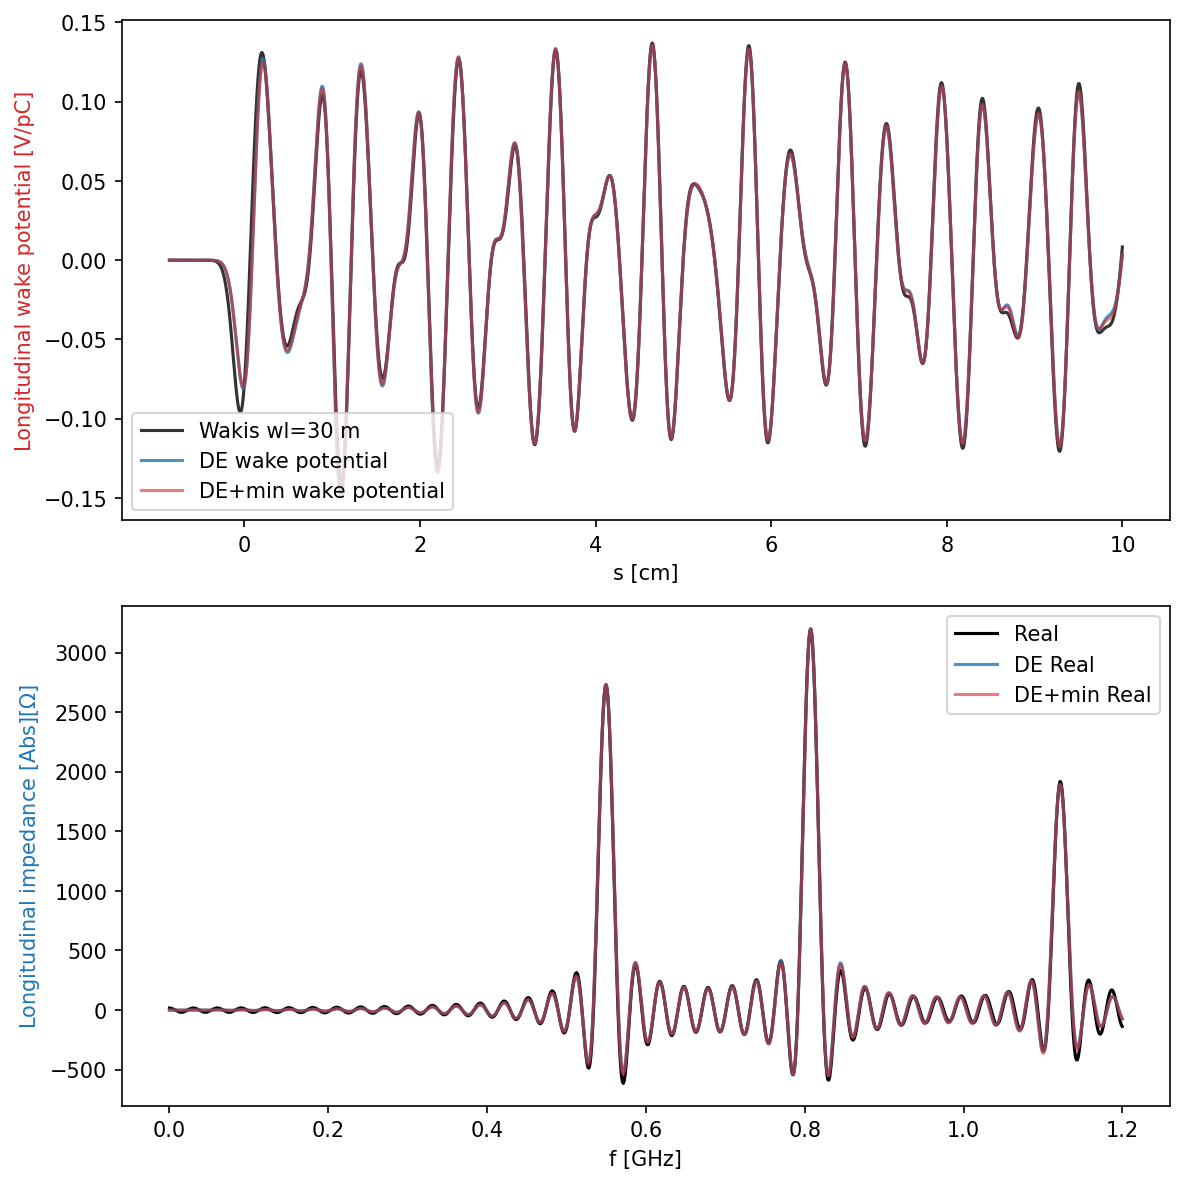

In [10]:
#%matplotlib ipympl

# Retrieve partially decayed wake potential
WP_pd = DE_model.get_wake_potential(wake.s/c, sigma=10e-2/c, use_minimization=False)
WP_pd_min = DE_model.get_wake_potential(wake.s/c, sigma=10e-2/c, use_minimization=True)

# Retrieve partially decayed impedance
f_pd = np.linspace(0, 1.2e9, 10000)
Z_pd = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=False)
Z_pd_min = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=True)

fig1, ax = plt.subplots(2,1, figsize=[8,8], dpi=150)

ax[0].plot(wake.s, wake.WP, c='k', alpha=0.8, label='Wakis wl=30 m')
ax[0].plot(wake.s, -WP_pd*1e-12, c='tab:blue', alpha=0.8, lw=1.5, label='DE wake potential')
ax[0].plot(wake.s, -WP_pd_min*1e-12, c='tab:red', alpha=0.6, lw=1.5, label='DE+min wake potential')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()

ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='-', c='k', lw=1.5, label='Real')
#ax[1].plot(f*1e-9, np.imag(Z), ls=':', c='k', lw=1.5, label='Imag')
#ax[1].plot(f*1e-9, np.real(Z_pd), c='tab:blue', label='Abs')

ax[1].plot(f_pd*1e-9, np.real(Z_pd), ls='-', c='tab:blue', alpha=0.8, lw=1.5, label='DE Real')
#ax[1].plot(f_pd*1e-9, np.imag(Z_pd), ls=':', c='tab:blue', alpha=0.6, lw=1.5, label='DE Imag')

ax[1].plot(f_pd*1e-9, np.real(Z_pd_min), ls='-', c='tab:red', alpha=0.6, lw=1.5, label='DE+min Real')

ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()

🏁 And once we trust the DE fitting, we can
plot the **fully decayed, extrapolated impedance**:

In [11]:
# retrieve the wake potential, function and impedance analytically using the resonator formalism
new_wakelength = 100 # [m]
sigmaz = 10e-2 #[m], the one used in the simulation

s, wake_potential = wake.get_extrapolated_wake(wakelength=new_wakelength, sigma=sigmaz/c, use_minimization=True)
t, wake_function = wake.get_extrapolated_wake_function(wakelength=new_wakelength, use_minimization=True)
f, impedance = wake.get_extrapolated_impedance(wakelength=new_wakelength, use_minimization=True)

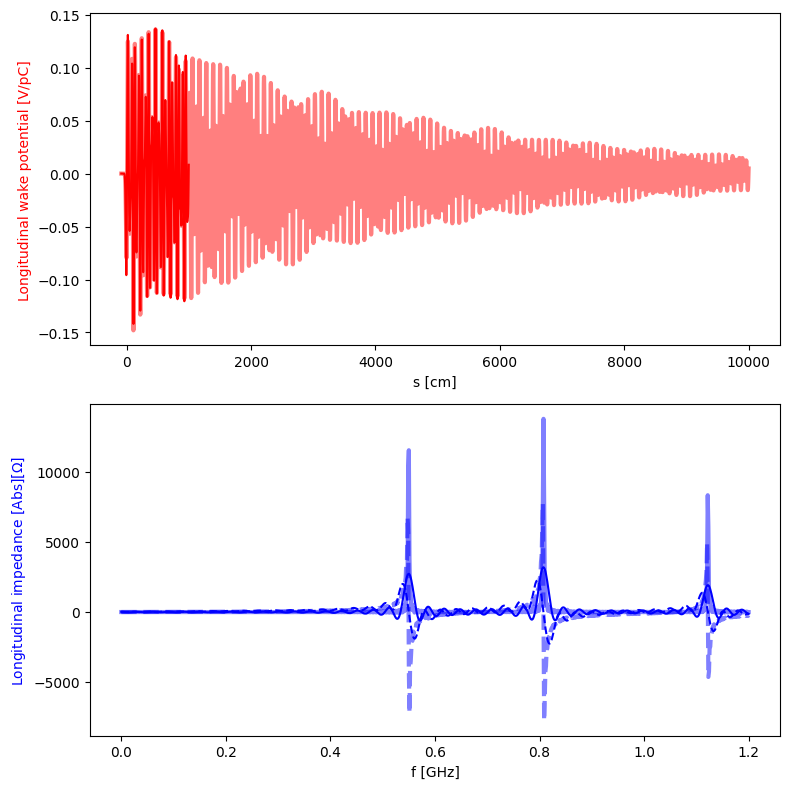

In [12]:
fig, ax = plt.subplots(2,1, figsize=[8,8], dpi=100)
ax[0].plot(wake.s*1e2, wake.WP, c='r', lw=1.5, label='Wakis')
ax[0].plot(s*1e2, wake_potential, c='r', lw=3, alpha=0.5, label='Wakis DE extrapolation')
#ax[0].plot(t*c_light*1e2, wake_function/c_light, c='grey', lw=1.5, alpha=0.5, label='Wakis DE extrapolation')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.real(wake.Z), c='b', lw=1.5, label='Wakis - Re')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), c='b', lw=1.5, ls='--', label='Wakis - Imag')

ax[1].plot(f*1e-9, np.real(impedance), c='b', lw=3, alpha=0.5, label='Wakis DE - Re')
ax[1].plot(f*1e-9, np.imag(impedance), c='b', lw=3, ls='--', alpha=0.5, label='Wakis DE - Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')

fig.tight_layout()